# Using SimEc for recommender systems
Tasks like product recommendation or drug-target interaction prediction essentially consist of having to predict missing entries in a large matrix containing pairwise relations, e.g., the user ratings of some items or whether or not a drug interacts with a certain protein. Besides the sparse matrix containing the pairwise relations, generally one can also construct some feature vectors for the items and users (drugs / proteins), e.g., based on textual descriptions. These can come in especially handy when predictions need to be made, e.g., for new items that did not receive any user ratings so far. In the following we will only talk about items and users but of course this extends to other problem setups as well like drug-target interaction prediction. We distinguish between 3 tasks with increasing difficulty:
- **T1**: Predict missing ratings for existing items and users
- **T2a** and **T2b**: Predict ratings for new items and existing users (a) or new users and existing items (b)
- **T3**: Predict ratings for new items and new users

For tasks T2a/b and T3, feature vectors describing items and/or users are required. 

There are several methods that can be used to solve some or all of the above tasks. These include:
##### Baseline Methods
- **Predict average**: This is a no-brainer: simply fill all the missing values by averages. For example, an item rating from a user can be predicted based on the average rating the user usually gives (he might in general be more or less critical than other users) and the average rating the item got from other users (it might be better or worse than the average item) or for new items and users just predict the overall average rating (solves **T1, T2a/b, T3**).
- **SVD of the ratings matrix**: By factorizing the ratings matrix using (iterative) singular value decomposition (SVD), one can compute a low rank approximation of the ratings matrix and use these approximate values as predictions for the missing values (solves **T1**). This can also be combined with the average ratings from above, i.e., the low rank approximation can be used to predict the residuals.
- **SVD + Regression**: Given some feature vectors for items or users and the low rank approximation of the ratings matrix computed above, using a regression model, the mapping from the items' feature vectors to their rating vectors can be learned (or respectively for users). This is an extension of the above method to additionally solve either **T2a** or **T2b**, or **T3** if models are learned for both sides of the factorization.
- **Regression/Classification model**: This approach is completely different from the so-called latent factor models discussed above. Here we train an ordinary regression or classification model (depending on the form of the pairwise data, e.g. continuous ratings or binary interactions) by using as input the concatenation of the feature vectors of an item and a user and as the target their rating. One possible realization of such a model could involve two neural networks to map the individual feature vectors into some lower dimensional embedding space. This approach can be used to solve all tasks **T1, T2a/b, T3** provided corresponding feature vectors are available.

##### Similarity Encoder Models
- **Factorization of the ratings matrix using the identity matrix as input**: By training a SimEc to factorize the ratings matrix using the identity matrix as input, we can recreate the solution obtained with SVD (while possibly better handling missing values when computing the decomposition). Correspondingly, this only solves **T1**.
- **Factorization of the ratings matrix using feature vectors as input**: By using either item or user feature vectors as input when factorizing the ratings matrix, we can additionally solve **T2a** or **T2b**.
- **Train a second SimEc with feature vectors and fixed last layer weights**: After training, e.g., a SimEc with item feature vectors as input to decompose the ratings matrix, we can use this SimEc to compute the item embeddings $Y$. We can then construct a second SimEc, which uses user feature vectors as input to factorize the ratings matrix. However, here we fix the weights of the last layer by setting them to the transpose of the embedding matrix computed for the items. After this SimEc is trained, we can now use both SimEcs to compute item and user embeddings respectively and then compute the scalar product of the embedding vectors to predict the ratings. This approach can then also be used to predict the ratings given the feature vectors for new items and users, i.e., it can be used to solve all tasks **T1, T2a/b, T3**.

If the rating matrix contains explicit ratings (i.e. likes and dislikes), all available entries can be used to train the above models. If the pairwise relations in the matrix only represent implicit feedback or binary interactions (e.g. the user listens to music by certain artists, which means he likes them, but we don't know if he doesn't listen to other artists because he doesn't know them or because he doesn't like them), then we can use the given entries in the matrix as positive examples and additionally take a random sample of the missing entries and use them as negative examples. In the latter case, it might be more useful to use classification instead of regression models and also when training the SimEc it could be helpful to apply a non-linearity on the output before computing the error of the model.


### Dataset
In this notebook we work with the [movielens dataset](https://grouplens.org/datasets/movielens/10m/) and additionally pull some information about the individual movies from [the movie database](https://api.themoviedb.org/) using their API.

Since we only have additional information about the movies, not the users, we focus on solving tasks **T1** and **T2a** here.

In [1]:
from __future__ import unicode_literals, division, print_function, absolute_import
from builtins import range, str
import os
import json
import requests
import numpy as np
np.random.seed(28)
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tf.set_random_seed(28)
import keras
import keras.backend as K

from collections import defaultdict, Counter
from scipy.sparse import lil_matrix, dok_matrix, csr_matrix, hstack, vstack, diags
from scipy.sparse.linalg import svds
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge as rreg
from sklearn.model_selection import GridSearchCV
from simec import SimilarityEncoder

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/franzi/anaconda2/envs/python36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Loading Data

In [2]:
if not os.path.exists("data/recsys/tmdb_data"):
    os.mkdir("data/recsys/tmdb_data")

def parse_tmdb(tmdbid, apikey):
    movie_data = {}
    if os.path.exists("data/recsys/tmdb_data/%r.json" % tmdbid):
        with open("data/recsys/tmdb_data/%r.json" % tmdbid) as f:
            movie_data = json.load(f)
    # for a movie with tmdbid get:
    # genres:name, original language en y/n, id, title, overview, release_date-->year,
    # keywords:keywords:name, credits:cast:name[:10], credits:crew:("job": "Director"):name
    if not movie_data:
        r = requests.get("https://api.themoviedb.org/3/movie/%r?api_key=%s&language=en-US&append_to_response=keywords,credits" % (tmdbid, apikey))
        if r.status_code != 200:
            print("something went wrong when accessing tmdb with id %r!" % tmdbid)
            print(r.text)
        else:
            movie_json = r.json()
            movie_data['tmdbid'] = movie_json['id']
            movie_data['title'] = movie_json['title']
            movie_data['overview'] = movie_json['overview']
            movie_data['release_date'] = movie_json['release_date']
            movie_data['year'] = movie_json["release_date"].split("-")[0]
            movie_data['original_en'] = str(movie_json['original_language'] == "en")
            movie_data['genres'] = [g["name"] for g in movie_json['genres']]
            movie_data['keywords'] = [k["name"] for k in movie_json['keywords']['keywords']]
            movie_data['cast'] = [c["name"] for c in movie_json['credits']['cast'][:10]]
            movie_data['directors'] = [c["name"] for c in movie_json['credits']['crew'] if c["job"] == "Director"]
            print("got data for %s" % movie_json['title'])
            with open("data/recsys/tmdb_data/%r.json" % tmdbid, "w") as f:
                json.dump(movie_data, f, indent=2)
    return movie_data

In [3]:
# get movielens data from: https://grouplens.org/datasets/movielens/10m/
# load all possible movies (in the 10m dataset)
df_movies = pd.read_csv("data/recsys/ml-10M100K/movies.dat", sep="::", names=["movieId","title","genres"])
# get corresponding tmdbids (only in 20m dataset)
df_links = pd.read_csv("data/recsys/ml-20m/links.csv")
df_links = df_links.dropna()
df_links = df_links.astype(int) 
map_movieids = dict(zip(df_links.movieId, df_links.tmdbId))
# get additional details from themoviedb.org (assumes api key is stored at data/recsys/tmdb_apikey.txt)
if os.path.exists("data/recsys/tmdb_data.json"):
    with open("data/recsys/tmdb_data.json") as f:
        movies_data = json.load(f)
else:
    movies_data = {}
    with open('data/recsys/tmdb_apikey.txt') as f:
        apikey = f.read().strip()
    for movieid in df_movies.movieId:
        if movieid in map_movieids:
            m = parse_tmdb(map_movieids[movieid], apikey)
            if m:
                # careful: when loading the json later the ids will be strings as well anyways
                movies_data[str(movieid)] = m
            else:
                print("error with movie id: %i" % movieid)
    with open("data/recsys/tmdb_data.json", "w") as f:
        json.dump(movies_data, f, indent=2)
print("got data for %i movies" % len(movies_data))

got data for 10608 movies


/home/franzi/anaconda2/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
# load pairwise data and generate a dict with {(movieid, userid): rating}
movieids = set()
userids = set()
tuple_ratings = {}
rating_pairs = []
with open("data/recsys/ml-10M100K/ratings.dat") as f:
    for i, l in enumerate(f.readlines()):
        if not i % 1000000:
            print("parsed %i lines" % i)
        u, m, r, t = l.strip().split("::")
        # only consider ratings for movies where we have external data available
        if m in movies_data:
            # in addition to the ratings, also get a list of all users and movies
            if u not in userids:
                userids.add(u)
            if m not in movieids:
                movieids.add(m)
            tuple_ratings[(m,u)] = float(r)
            rating_pairs.append((m,u))
        #else:
        #    print("warning, skipping rating for movie with id %r" % m)
# shuffle all movie and user ids (important so we can split data into train and test sets)
# this list additionally functions as a mapping from a (matrix) index to the actual id
np.random.seed(13)
map_index2movieid = np.random.permutation(sorted(movieids))
map_index2userid = np.random.permutation(sorted(userids))
# also get a shuffeled list of all rating pairs
rating_pairs = np.random.permutation(rating_pairs)
print("%i movies, %i users, and %i ratings" % (len(movieids), len(userids), len(rating_pairs)))

parsed 0 lines
parsed 1000000 lines
parsed 2000000 lines
parsed 3000000 lines
parsed 4000000 lines
parsed 5000000 lines
parsed 6000000 lines
parsed 7000000 lines
parsed 8000000 lines
parsed 9000000 lines
parsed 10000000 lines
10604 movies, 69878 users, and 9989664 ratings


## Ratings Prediction
#### Overview of prediction results (RMSE)

|  | mean | mean+SVD | mean+SimEc(I) | mean+SVD+regression | mean+SimEc(X) |
| --- | --- | --- | --- | --- | --- |
| **T1** | 0.88614 | **0.85891** | 0.87836 | 0.88025 | 0.86800 |
| **T2a** | 0.97610 | - | - | 0.97340 | **0.96889** |

While the SVD of the residual ratings matrix gives the best approximation of the ratings for known movies and users (T1), learning the connection between the movies' feature vectors and the pairwise relations with a SimEc enables us to make better prediction for new movies (T2a).

In [5]:
# we have different scenarios: either we're only missing some individual ratings or entire movies/users
def split_traintest(scenario):
    print("generating train/test splits for scenario %r" % scenario)
    if scenario == "T1":
        # missing ratings
        rating_pairs_train = rating_pairs[:int(0.7*len(rating_pairs))]
        rating_pairs_test = rating_pairs[int(0.7*len(rating_pairs)):]
        map_index2movieid_train = map_index2movieid
        map_index2userid_train = map_index2userid
    else:
        rating_pairs_train = []
        rating_pairs_test = []
        if scenario == "T2a":
            # missing movies
            map_index2movieid_train = map_index2movieid[:int(0.7*len(map_index2movieid))]
            map_index2userid_train = map_index2userid
        elif scenario == "T2b":
            # missing users
            map_index2movieid_train = map_index2movieid
            map_index2userid_train = map_index2userid[:int(0.7*len(map_index2userid))]
        elif scenario == "T3":
            # missing movies and users
            map_index2movieid_train = map_index2movieid[:int(0.85*len(map_index2movieid))]
            map_index2userid_train = map_index2userid[:int(0.8*len(map_index2userid))]
        else:
            raise Exception("unknown scenario %r, use either T1, T2a, T2b, or T3!" % scenario)
        movieids_train_set = set(map_index2movieid_train)
        userids_train_set = set(map_index2userid_train)
        rating_pairs_train = []
        rating_pairs_test = []
        for (m, u) in rating_pairs:
            if u in userids_train_set and m in movieids_train_set:
                rating_pairs_train.append((m, u))
            else:
                rating_pairs_test.append((m, u))
    print("got %i training and %i test ratings" % (len(rating_pairs_train), len(rating_pairs_test)))
    # create mappings from the actual id to the index
    map_movieid2index_train = {m: i for i, m in enumerate(map_index2movieid_train)}
    map_userid2index_train = {u: i for i, u in enumerate(map_index2userid_train)}
    return rating_pairs_train, rating_pairs_test, map_index2userid_train,\
           map_index2movieid_train, map_userid2index_train, map_movieid2index_train

def make_train_matrix(tuple_ratings, rating_pairs_train, map_userid2index_train, map_movieid2index_train):
    # transform training ratings into a sparse matrix for convenience
    print("transforming dict with %i ratings into sparse matrix" % len(rating_pairs_train))
    ratings_matrix = lil_matrix((len(map_movieid2index_train),len(map_userid2index_train)))
    for (m, u) in rating_pairs_train:
        ratings_matrix[map_movieid2index_train[m],map_userid2index_train[u]] = tuple_ratings[(m, u)]
    ratings_matrix = csr_matrix(ratings_matrix)
    return ratings_matrix

### Baseline model: predict mean

In [6]:
class MeansModel():
    """
    A very simple baseline model, which predicts the rating a user would give to a movie as:
        mean + user_mean + movie_mean
    """
    def __init__(self, shrinkage=1.):
        self.mean = None
        self.mean_users = {}
        self.mean_movies = {}
        # shrinkage decreases the influence of the individual user/movie means
        # --> mean + shrinkage*user_mean + shrinkage*movie_mean
        # it should always be between 0 and 1; 0 means individual means are ignored
        self.shrinkage = max(0., min(1., shrinkage))

    def fit(self, tuple_ratings, rating_pairs_train):
        # overall mean based on all training ratings
        self.mean = np.mean([tuple_ratings[(m, u)] for (m, u) in rating_pairs_train])
        # means for movies and users
        if self.shrinkage:
            mean_users = defaultdict(list)
            mean_movies = defaultdict(list)
            for (m, u) in rating_pairs_train:
                mean_users[u].append(tuple_ratings[(m, u)])
                mean_movies[m].append(tuple_ratings[(m, u)])
            self.mean_users = {u: np.mean(mean_users[u])-self.mean for u in mean_users}
            self.mean_movies = {m: np.mean(mean_movies[m])-self.mean for m in mean_movies}
    
    def predict(self, m, u, residuals=None):
        """
        generate rating prediction for a user u and movie m
        """
        rating = self.mean
        if u in self.mean_users:
            rating += self.shrinkage*self.mean_users[u]
        if m in self.mean_movies:
            rating += self.shrinkage*self.mean_movies[m]
        if residuals and (m, u) in residuals:
            rating += residuals[(m, u)]
        return rating
    
    def compute_residuals(self, tuple_ratings, rating_pairs_train):
        """
        for all ratings, subtract the respective average ratings to get residuals
        """
        return {(m, u): tuple_ratings[(m, u)] - (self.mean+self.shrinkage*(self.mean_users[u]+self.mean_movies[m]))
                                  for (m, u) in rating_pairs_train}

In [7]:
for scenario in ["T1", "T2a", "T2b", "T3"]:
    # get train/test data
    rating_pairs_train, rating_pairs_test, map_index2userid_train, map_index2movieid_train, map_userid2index_train, map_movieid2index_train = split_traintest(scenario)
    for shrinkage in [0., 0.1, 0.5, 0.9, 1.]:
        # initalize means model
        mmodel = MeansModel(shrinkage)
        print("fitting model with shrinkage=%.1f" % shrinkage)
        mmodel.fit(tuple_ratings, rating_pairs_train)
        # get a vector with target ratings for test tuples
        y_true = np.array([tuple_ratings[(m, u)] for (m, u) in rating_pairs_test])
        # get the corresponding predictions
        y_pred = np.array([mmodel.predict(m, u) for (m, u) in rating_pairs_test])
        print("Scenario %s: RMSE: %.5f; MAE: %.5f" % (scenario, np.sqrt(mean_squared_error(y_true, y_pred)), mean_absolute_error(y_true, y_pred)))

generating train/test splits for scenario 'T1'
got 6992764 training and 2996900 test ratings
fitting model with shrinkage=0.0
Scenario T1: RMSE: 1.06044; MAE: 0.85552
fitting model with shrinkage=0.1
Scenario T1: RMSE: 1.02330; MAE: 0.82574
fitting model with shrinkage=0.5
Scenario T1: RMSE: 0.91333; MAE: 0.71937
fitting model with shrinkage=0.9
Scenario T1: RMSE: 0.88074; MAE: 0.68157
fitting model with shrinkage=1.0
Scenario T1: RMSE: 0.88614; MAE: 0.68404
generating train/test splits for scenario 'T2a'
got 7064138 training and 2925526 test ratings
fitting model with shrinkage=0.0
Scenario T2a: RMSE: 1.05938; MAE: 0.85143
fitting model with shrinkage=0.1
Scenario T2a: RMSE: 1.04342; MAE: 0.83821
fitting model with shrinkage=0.5
Scenario T2a: RMSE: 0.99569; MAE: 0.79322
fitting model with shrinkage=0.9
Scenario T2a: RMSE: 0.97628; MAE: 0.76558
fitting model with shrinkage=1.0
Scenario T2a: RMSE: 0.97610; MAE: 0.76332
generating train/test splits for scenario 'T2b'
got 7015197 training

### Baseline model: SVD of residuals

In [8]:
scenario = "T1"
# get train/test data
rating_pairs_train, rating_pairs_test, map_index2userid_train, map_index2movieid_train, map_userid2index_train, map_movieid2index_train = split_traintest(scenario)
# initalize and fit means model
mmodel = MeansModel()
mmodel.fit(tuple_ratings, rating_pairs_train)
# get sparse matrix with residuals
print("computing residuals")
residual_ratings = mmodel.compute_residuals(tuple_ratings, rating_pairs_train)
ratings_matrix = make_train_matrix(residual_ratings, rating_pairs_train, map_userid2index_train, map_movieid2index_train)

generating train/test splits for scenario 'T1'
got 6992764 training and 2996900 test ratings
computing residuals
transforming dict with 6992764 ratings into sparse matrix


Text(0.5,0,'eigenvalue')

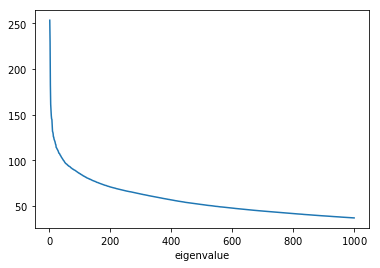

In [9]:
# inspect eigenvalues of matrix
eigenvals = svds(ratings_matrix, k=1000, return_singular_vectors=False)
eigenvals = sorted(eigenvals, reverse=True)
plt.figure()
plt.plot(list(range(1, len(eigenvals)+1)), eigenvals)
plt.xlabel("eigenvalue")

In [10]:
# get eigenvalues and -vectors for some relevant dimensions
e_dim = 100
U, s, Vh = svds(ratings_matrix, k=e_dim)
S = np.zeros((e_dim, e_dim))
S = np.diag(s)
U.shape, S.shape, Vh.shape

((10604, 100), (100, 100), (100, 69878))

In [11]:
# construct approximation of residual ratings
print("get approximations")
temp = np.dot(U, np.dot(S, Vh))
# get dict with residuals for missing test ratings
print("get residual ratings")
residual_ratings_test = {(m, u): temp[map_movieid2index_train[m], map_userid2index_train[u]]
                                 for (m, u) in rating_pairs_test}
del temp
print("predict test ratings")
# get a vector with target ratings for test tuples
y_true = np.array([tuple_ratings[(m, u)] for (m, u) in rating_pairs_test])
# get the corresponding predictions
y_pred = np.array([mmodel.predict(m, u, residual_ratings_test) for (m, u) in rating_pairs_test])
print("Scenario %s: RMSE: %.5f; MAE: %.5f" % (scenario, np.sqrt(mean_squared_error(y_true, y_pred)), mean_absolute_error(y_true, y_pred)))

get approximations
get residual ratings
predict test ratings
Scenario T1: RMSE: 0.85891; MAE: 0.65994


### SimEc model: identity matrix as input

In [12]:
# get a vector with target ratings for test tuples
y_true = np.array([tuple_ratings[(m, u)] for (m, u) in rating_pairs_test])
# train simec with identiy matrix as input to predict residuals
e_dim = 100
X = np.eye(ratings_matrix.shape[0], dtype=np.float16)
model = SimilarityEncoder(ratings_matrix.shape[0], e_dim, ratings_matrix.shape[1], opt=0.05)
model.fit(X, ratings_matrix, epochs=20)
print("get approximations")
temp = np.array(model.predict(X), dtype=np.float16)
# get dict with residuals for missing test ratings
print("get residual ratings")
residual_ratings_test = {(m, u): temp[map_movieid2index_train[m], map_userid2index_train[u]]
                                 for (m, u) in rating_pairs_test}
del temp
print("predict test ratings")
# get the corresponding predictions
y_pred = np.array([mmodel.predict(m, u, residual_ratings_test) for (m, u) in rating_pairs_test])
print("Scenario %s: RMSE: %.5f; MAE: %.5f" % (scenario, np.sqrt(mean_squared_error(y_true, y_pred)), mean_absolute_error(y_true, y_pred)))

Epoch 1/20
10604/10604 [==============================] - 33s 3ms/step - loss: 0.0073
Epoch 2/20
10604/10604 [==============================] - 32s 3ms/step - loss: 0.0073
Epoch 3/20
10604/10604 [==============================] - 32s 3ms/step - loss: 0.0073
Epoch 4/20
10604/10604 [==============================] - 32s 3ms/step - loss: 0.0073
Epoch 5/20
10604/10604 [==============================] - 33s 3ms/step - loss: 0.0073
Epoch 6/20
10604/10604 [==============================] - 32s 3ms/step - loss: 0.0073
Epoch 7/20
10604/10604 [==============================] - 32s 3ms/step - loss: 0.0073
Epoch 8/20
10604/10604 [==============================] - 33s 3ms/step - loss: 0.0073
Epoch 9/20
10604/10604 [==============================] - 33s 3ms/step - loss: 0.0073
Epoch 10/20
10604/10604 [==============================] - 33s 3ms/step - loss: 0.0073
Epoch 11/20
10604/10604 [==============================] - 33s 3ms/step - loss: 0.0073
Epoch 12/20
10604/10604 [===========================

### Construct feature vectors for movies

In [13]:
def features2mat(movies_data, movieids, feature, featurenames=[]):
    if not featurenames:
        featurenames = sorted(set(word for m in movieids for word in movies_data[m][feature]))
    fnamedict = {feat: i for i, feat in enumerate(featurenames)}
    featmat = dok_matrix((len(movieids), len(featurenames)), dtype=np.float16)
    for i, m in enumerate(movieids):
        for word in movies_data[m][feature]:
            try:
                featmat[i, fnamedict[word]] = 1.
            except KeyError:
                pass
    featmat = csr_matrix(featmat)
    return featmat, featurenames

def get_features_mats(movieids_train, movieids_test):
    featurenames = []
    genres_mat_train, genres_names = features2mat(movies_data, movieids_train, "genres")
    featurenames.extend(genres_names)
    genres_mat_test, _ = features2mat(movies_data, movieids_test, "genres", genres_names)
    keywords_mat_train, keywords_names = features2mat(movies_data, movieids_train, "keywords")
    featurenames.extend(keywords_names)
    keywords_mat_test, _ = features2mat(movies_data, movieids_test, "keywords", keywords_names)
    directors_mat_train, directors_names = features2mat(movies_data, movieids_train, "directors")
    featurenames.extend(directors_names)
    directors_mat_test, _ = features2mat(movies_data, movieids_test, "directors", directors_names)
    feat_mat_train = hstack([genres_mat_train, keywords_mat_train, directors_mat_train], format="csr", dtype=np.float16)
    feat_mat_test = hstack([genres_mat_test, keywords_mat_test, directors_mat_test], format="csr", dtype=np.float16)
    return feat_mat_train, feat_mat_test, featurenames

### Baseline model: SVD of residuals with regression

In [14]:
## for T1 same scenario as above
scenario = "T1"
# get train/test data
rating_pairs_train, rating_pairs_test, map_index2userid_train, map_index2movieid_train, map_userid2index_train, map_movieid2index_train = split_traintest(scenario)
# train and test movies are the same, i.e., no unknown movies
feat_mat_train, _, _ = get_features_mats(map_index2movieid_train, [])
# initalize and fit means model
mmodel = MeansModel()
mmodel.fit(tuple_ratings, rating_pairs_train)
# get sparse matrix with residuals
print("computing residuals")
residual_ratings = mmodel.compute_residuals(tuple_ratings, rating_pairs_train)
ratings_matrix = make_train_matrix(residual_ratings, rating_pairs_train, map_userid2index_train, map_movieid2index_train)
# get eigenvalues and -vectors for some relevant dimensions
e_dim = 100
U, s, Vh = svds(ratings_matrix, k=e_dim)
S = np.zeros((e_dim, e_dim))
S = np.diag(s)
# train regression model to map from feat_mat to U
print("train regression model")
alpha = 250.  # None to do grid search
if alpha is None:
    m = rreg()
    rrm = GridSearchCV(m, {'alpha': [0.01, 0.1, 0.25, 0.5, 0.75, 1., 2.5 , 5., 7.5, 10., 25., 50., 75., 100., 250., 500., 750., 1000.]})
    rrm.fit(feat_mat_train, U)
    print("best alpha: ", rrm.best_params_)
else:
    rrm = rreg(alpha=alpha)
    rrm.fit(feat_mat_train, U)
U_pred = rrm.predict(feat_mat_train)
# construct approximation of residual ratings
print("get approximations")
temp = np.dot(U_pred, np.dot(S, Vh))
# get dict with residuals for missing test ratings
print("get residual ratings")
residual_ratings_test = {(m, u): temp[map_movieid2index_train[m], map_userid2index_train[u]]
                                 for (m, u) in rating_pairs_test}
del temp
print("predict test ratings")
# get a vector with target ratings for test tuples
y_true = np.array([tuple_ratings[(m, u)] for (m, u) in rating_pairs_test])
# get the corresponding predictions
y_pred = np.array([mmodel.predict(m, u, residual_ratings_test) for (m, u) in rating_pairs_test])
print("Scenario %s: RMSE: %.5f; MAE: %.5f" % (scenario, np.sqrt(mean_squared_error(y_true, y_pred)), mean_absolute_error(y_true, y_pred)))

generating train/test splits for scenario 'T1'
got 6992764 training and 2996900 test ratings
computing residuals
transforming dict with 6992764 ratings into sparse matrix
train regression model
get approximations
get residual ratings
predict test ratings
Scenario T1: RMSE: 0.88025; MAE: 0.67904


In [15]:
scenario = "T2a"
# get train/test data
rating_pairs_train, rating_pairs_test, map_index2userid_train, map_index2movieid_train, map_userid2index_train, map_movieid2index_train = split_traintest(scenario)
movieids_test = sorted(set(m for (m, u) in rating_pairs_test if m not in map_movieid2index_train))
map_movieid2index_all = {m : i for i, m in enumerate(movieids_test, len(map_movieid2index_train))}
map_movieid2index_all.update(map_movieid2index_train)
feat_mat_train, feat_mat_test, _ = get_features_mats(map_index2movieid_train, movieids_test)
# initalize and fit means model
mmodel = MeansModel()
mmodel.fit(tuple_ratings, rating_pairs_train)
# get sparse matrix with residuals
print("computing residuals")
residual_ratings = mmodel.compute_residuals(tuple_ratings, rating_pairs_train)
ratings_matrix = make_train_matrix(residual_ratings, rating_pairs_train, map_userid2index_train, map_movieid2index_train)
# get eigenvalues and -vectors for some relevant dimensions
e_dim = 100
U, s, Vh = svds(ratings_matrix, k=e_dim)
S = np.zeros((e_dim, e_dim))
S = np.diag(s)
# train regression model to map from feat_mat to U
print("train regression model")
rrm = rreg(alpha=250.)
rrm.fit(feat_mat_train, U)
# stack train and test feature matrices to make predictions for all
feat_mat_all = vstack([feat_mat_train, feat_mat_test], format="csr", dtype=np.float16)
del feat_mat_train, feat_mat_test
U_pred = rrm.predict(feat_mat_all)
# construct approximation of residual ratings
print("get approximations")
temp = np.dot(U_pred, np.dot(S, Vh))
# get dict with residuals for missing test ratings
print("get residual ratings")
residual_ratings_test = {(m, u): temp[map_movieid2index_all[m], map_userid2index_train[u]]
                                 for (m, u) in rating_pairs_test}
del temp
print("predict test ratings")
# get a vector with target ratings for test tuples
y_true = np.array([tuple_ratings[(m, u)] for (m, u) in rating_pairs_test])
# get the corresponding predictions
y_pred = np.array([mmodel.predict(m, u, residual_ratings_test) for (m, u) in rating_pairs_test])
print("Scenario %s: RMSE: %.5f; MAE: %.5f" % (scenario, np.sqrt(mean_squared_error(y_true, y_pred)), mean_absolute_error(y_true, y_pred)))

generating train/test splits for scenario 'T2a'
got 7064138 training and 2925526 test ratings
computing residuals
transforming dict with 7064138 ratings into sparse matrix
train regression model


/home/franzi/anaconda2/envs/python36/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


get approximations
get residual ratings
predict test ratings
Scenario T2a: RMSE: 0.97340; MAE: 0.76115


### SimEc model: feature matrix as input

In [16]:
## for T1 same scenario as above
scenario = "T1"
# get train/test data
rating_pairs_train, rating_pairs_test, map_index2userid_train, map_index2movieid_train, map_userid2index_train, map_movieid2index_train = split_traintest(scenario)
# train and test movies are the same, i.e., no unknown movies
feat_mat_train, _, _ = get_features_mats(map_index2movieid_train, [])
# initalize and fit means model
mmodel = MeansModel()
mmodel.fit(tuple_ratings, rating_pairs_train)
# get sparse matrix with residuals
print("computing residuals")
residual_ratings = mmodel.compute_residuals(tuple_ratings, rating_pairs_train)
ratings_matrix = make_train_matrix(residual_ratings, rating_pairs_train, map_userid2index_train, map_movieid2index_train)
# get a vector with target ratings for test tuples
y_true = np.array([tuple_ratings[(m, u)] for (m, u) in rating_pairs_test])
# train simec with identiy matrix as input to predict residuals
e_dim = 100
model = SimilarityEncoder(feat_mat_train.shape[1], e_dim, ratings_matrix.shape[1], sparse_inputs=True,
                          opt=0.0075)
model.fit(feat_mat_train, ratings_matrix, epochs=20)
print("get approximations")
temp = np.array(model.predict(feat_mat_train), dtype=np.float16)
# get dict with residuals for missing test ratings
print("get residual ratings")
residual_ratings_test = {(m, u): temp[map_movieid2index_train[m], map_userid2index_train[u]]
                                 for (m, u) in rating_pairs_test}
del temp
print("predict test ratings")
# get the corresponding predictions
y_pred = np.array([mmodel.predict(m, u, residual_ratings_test) for (m, u) in rating_pairs_test])
print("Scenario %s: RMSE: %.5f; MAE: %.5f" % (scenario, np.sqrt(mean_squared_error(y_true, y_pred)), mean_absolute_error(y_true, y_pred)))

generating train/test splits for scenario 'T1'
got 6992764 training and 2996900 test ratings
computing residuals
transforming dict with 6992764 ratings into sparse matrix
Epoch 1/20
10604/10604 [==============================] - 32s 3ms/step - loss: 0.0073
Epoch 2/20
10604/10604 [==============================] - 32s 3ms/step - loss: 0.0072
Epoch 3/20
10604/10604 [==============================] - 32s 3ms/step - loss: 0.0072
Epoch 4/20
10604/10604 [==============================] - 32s 3ms/step - loss: 0.0072
Epoch 5/20
10604/10604 [==============================] - 32s 3ms/step - loss: 0.0072
Epoch 6/20
10604/10604 [==============================] - 32s 3ms/step - loss: 0.0072
Epoch 7/20
10604/10604 [==============================] - 32s 3ms/step - loss: 0.0072
Epoch 8/20
10604/10604 [==============================] - 32s 3ms/step - loss: 0.0072
Epoch 9/20
10604/10604 [==============================] - 32s 3ms/step - loss: 0.0072
Epoch 10/20
10604/10604 [==============================

In [17]:
scenario = "T2a"
# get train/test data
rating_pairs_train, rating_pairs_test, map_index2userid_train, map_index2movieid_train, map_userid2index_train, map_movieid2index_train = split_traintest(scenario)
movieids_test = sorted(set(m for (m, u) in rating_pairs_test if m not in map_movieid2index_train))
map_movieid2index_all = {m : i for i, m in enumerate(movieids_test, len(map_movieid2index_train))}
map_movieid2index_all.update(map_movieid2index_train)
feat_mat_train, feat_mat_test, _ = get_features_mats(map_index2movieid_train, movieids_test)
# stack train and test feature matrices to make predictions for all
feat_mat_all = vstack([feat_mat_train, feat_mat_test], format="csr", dtype=np.float16)
del feat_mat_test
# initalize and fit means model
mmodel = MeansModel()
mmodel.fit(tuple_ratings, rating_pairs_train)
# get sparse matrix with residuals
print("computing residuals")
residual_ratings = mmodel.compute_residuals(tuple_ratings, rating_pairs_train)
ratings_matrix = make_train_matrix(residual_ratings, rating_pairs_train, map_userid2index_train, map_movieid2index_train)
# get a vector with target ratings for test tuples
y_true = np.array([tuple_ratings[(m, u)] for (m, u) in rating_pairs_test])
# train simec with identiy matrix as input to predict residuals
e_dim = 100
model = SimilarityEncoder(feat_mat_train.shape[1], e_dim, ratings_matrix.shape[1], sparse_inputs=True,
                          opt=0.005)
model.fit(feat_mat_train, ratings_matrix, epochs=20)
print("get approximations")
temp = np.array(model.predict(feat_mat_all), dtype=np.float16)
# get dict with residuals for missing test ratings
print("get residual ratings")
residual_ratings_test = {(m, u): temp[map_movieid2index_all[m], map_userid2index_train[u]]
                                 for (m, u) in rating_pairs_test}
del temp
print("predict test ratings")
# get the corresponding predictions
y_pred = np.array([mmodel.predict(m, u, residual_ratings_test) for (m, u) in rating_pairs_test])
print("Scenario %s: RMSE: %.5f; MAE: %.5f" % (scenario, np.sqrt(mean_squared_error(y_true, y_pred)), mean_absolute_error(y_true, y_pred)))

generating train/test splits for scenario 'T2a'
got 7064138 training and 2925526 test ratings
computing residuals
transforming dict with 7064138 ratings into sparse matrix
Epoch 1/20
7422/7422 [==============================] - 23s 3ms/step - loss: 0.0104
Epoch 2/20
7422/7422 [==============================] - 22s 3ms/step - loss: 0.0104
Epoch 3/20
7422/7422 [==============================] - 23s 3ms/step - loss: 0.0104
Epoch 4/20
7422/7422 [==============================] - 23s 3ms/step - loss: 0.0103
Epoch 5/20
7422/7422 [==============================] - 23s 3ms/step - loss: 0.0103
Epoch 6/20
7422/7422 [==============================] - 23s 3ms/step - loss: 0.0103
Epoch 7/20
7422/7422 [==============================] - 23s 3ms/step - loss: 0.0102
Epoch 8/20
7422/7422 [==============================] - 23s 3ms/step - loss: 0.0102
Epoch 9/20
7422/7422 [==============================] - 23s 3ms/step - loss: 0.0101
Epoch 10/20
7422/7422 [==============================] - 23s 3ms/step - 

## Interpretation of ratings

In addition to accurately predicting a user's rating for a certain item and therefore generating valuable recommendations, it might also be interesting to understand _why_ a user might like a certain item. For this, we can use [_layerwise relevance propagation_](http://heatmapping.org/) to identify the features of an item that most contributed to a positive or negative predicted rating.

In [18]:
# select an interesting movies that appeals to different kinds of audiences
# e.g. 8874 Shaun of the Dead
for mid in movies_data:
    if "Comedy" in movies_data[mid]["genres"] and "Horror" in movies_data[mid]["genres"] and movies_data[mid]["year"] > "2000":
        print(mid, movies_data[mid]["title"])

6755 Bubba Ho-tep
51498 2001 Maniacs
48678 Feast
44777 Evil Aliens
1115 The Sleepover
54910 Behind the Mask: The Rise of Leslie Vernon
62008 Dead Fury
32314 Incident at Loch Ness
7846 Tremors 3: Back to Perfection
5478 Eight Legged Freaks
60522 The Machine Girl
60044 Baghead
8578 Undead
27563 The Happiness of the Katakuris
32239 Save the Green Planet!
7266 The Lost Skeleton of Cadavra
48231 Taxidermia
7202 Beyond Re-Animator
44828 Slither
57910 Teeth
32011 Cursed
8874 Shaun of the Dead
5837 Legion of the Dead
47937 Severance
60363 Zombie Strippers!
8258 Citizen Toxie: The Toxic Avenger IV
4996 Little Otik
7319 Club Dread
5909 Visitor Q
53468 Fido
55553 Black Sheep


In [19]:
# check which users have given the movie a 5 star rating
users = []
for (m, u) in tuple_ratings:
    if m == "8874" and tuple_ratings[(m, u)] >= 5:
        users.append(u)
# sort these users by the most ratings
users = {u: len([1 for (m, x) in tuple_ratings if u==x]) for u in users}
for u in sorted(users, key=users.get, reverse=True):
    print(u, users[u])

3817 4159
14134 2750
38928 2552
43992 2444
67542 2333
33399 2257
24695 2235
55005 2176
57481 2129
30977 2110
18278 1886
69714 1863
63905 1804
6845 1662
41391 1597
54922 1582
3810 1560
36827 1512
9181 1473
3022 1424
44041 1406
37412 1396
9139 1381
16992 1368
12367 1361
23988 1333
48717 1291
19111 1205
28855 1195
35015 1191
18692 1149
36585 1138
18870 1125
42242 1121
27313 1088
55433 1079
34324 1077
70116 1076
30275 1070
59934 1051
35779 1047
23733 1045
60100 1044
47579 1033
3171 1028
32501 1013
41130 1005
18717 1002
8930 987
41394 969
16963 965
37430 964
49009 949
66543 949
1854 915
7678 913
5226 908
64718 902
61141 883
8683 881
66519 880
48933 855
31152 845
11638 837
29268 831
19669 823
38373 819
3336 818
48919 812
28128 808
16163 800
1771 798
1805 775
38322 775
30493 765
10799 764
28460 756
62293 753
46956 745
50311 741
57862 736
16058 735
35105 733
44500 731
43364 728
70332 723
52610 720
68986 720
29218 714
25502 705
48842 698
70516 687
65949 684
40234 683
66795 678
12207 675
23485 6

In [20]:
# check which genres the users like the most
# Horror is high ranked
genres = []
for (m, u) in residual_ratings:
    if u == "3817" and residual_ratings[(m, u)] >= 1:
        genres.extend(movies_data[m]["genres"])
genres = Counter(genres)
for g in sorted(genres, key=genres.get, reverse=True):
    print(g, genres[g])

Horror 122
Comedy 106
Thriller 100
Drama 76
Mystery 46
Action 46
Science Fiction 41
Crime 36
Adventure 35
Romance 30
Fantasy 23
Family 12
Music 4
Western 2
War 2
Documentary 2
History 1


In [21]:
# check which genres the users like the most
# Comedy is high ranked, Horror scores low
genres = []
for (m, u) in residual_ratings:
    if u == "14134" and residual_ratings[(m, u)] >= 1:
        genres.extend(movies_data[m]["genres"])
genres = Counter(genres)
for g in sorted(genres, key=genres.get, reverse=True):
    print(g, genres[g])

Drama 157
Comedy 104
Thriller 55
Romance 53
Crime 49
Action 34
Adventure 26
Mystery 23
Fantasy 17
History 17
War 16
Horror 15
Science Fiction 12
Documentary 12
Western 9
Music 9
Family 9
Animation 4
TV Movie 1


In [22]:
## train a simec model on all the data
rating_pairs_train, rating_pairs_test, map_index2userid_train, map_index2movieid_train, map_userid2index_train, map_movieid2index_train = split_traintest("T1")
rating_pairs_train, rating_pairs_test = list(rating_pairs_train), list(rating_pairs_test)
rating_pairs_train.extend(rating_pairs_test)
feat_mat_train, _, featurenames = get_features_mats(map_index2movieid_train, [])
# initalize and fit means model
mmodel = MeansModel()
mmodel.fit(tuple_ratings, rating_pairs_train)
# get sparse matrix with residuals
print("computing residuals")
residual_ratings = mmodel.compute_residuals(tuple_ratings, rating_pairs_train)
ratings_matrix = make_train_matrix(residual_ratings, rating_pairs_train, map_userid2index_train, map_movieid2index_train)
# get dense ratings matrix with missing values = -100
R = -100*np.ones(ratings_matrix.shape, dtype=np.float16)
R[ratings_matrix.nonzero()] = ratings_matrix[ratings_matrix.nonzero()]
# train simec with identiy matrix as input to predict residuals
e_dim = 100
model = SimilarityEncoder(feat_mat_train.shape[1], e_dim, ratings_matrix.shape[1], sparse_inputs=True,
                          mask_value=-100, opt=0.005)
model.fit(feat_mat_train, ratings_matrix, epochs=40)
del R

generating train/test splits for scenario 'T1'
got 6992764 training and 2996900 test ratings
computing residuals
transforming dict with 9989664 ratings into sparse matrix
Epoch 1/40
10604/10604 [==============================] - 33s 3ms/step - loss: 0.0104
Epoch 2/40
10604/10604 [==============================] - 33s 3ms/step - loss: 0.0103
Epoch 3/40
10604/10604 [==============================] - 33s 3ms/step - loss: 0.0103
Epoch 4/40
10604/10604 [==============================] - 33s 3ms/step - loss: 0.0103
Epoch 5/40
10604/10604 [==============================] - 33s 3ms/step - loss: 0.0103
Epoch 6/40
10604/10604 [==============================] - 33s 3ms/step - loss: 0.0102
Epoch 7/40
10604/10604 [==============================] - 33s 3ms/step - loss: 0.0102
Epoch 8/40
10604/10604 [==============================] - 33s 3ms/step - loss: 0.0102
Epoch 9/40
10604/10604 [==============================] - 33s 3ms/step - loss: 0.0102
Epoch 10/40
10604/10604 [==============================

In [23]:
# for a certain movie, create a new feature matrix with the features on the diagonal
# to get relevancy scores for each separate feature (only works for linear SimEc)
m = "8874"
u1 = "3817"
u2 = "14134"
mid = map_movieid2index_train[m]
uid1 = map_userid2index_train[u1]
uid2 = map_userid2index_train[u2]
# check regular prediction scores
print(residual_ratings[(m,u1)], residual_ratings[(m,u2)])
print(model.predict(feat_mat_train[mid,:])[:,[uid1, uid2]])
f_movie = csr_matrix(diags(feat_mat_train[mid,:].toarray()[0], 0, shape=(feat_mat_train.shape[1], feat_mat_train.shape[1])))
# featurewise predictions need to be corrected for the bias
temp = np.dot((model.transform(f_movie) + (1/f_movie.count_nonzero() - 1.) * model.model.layers[1].get_weights()[1]), model.model.layers[2].get_weights()[0][:, [uid1, uid2]])
uid1_scores = {f: temp[i,0] for i, f in enumerate(featurenames) if f_movie[i,i]}
uid2_scores = {f: temp[i,1] for i, f in enumerate(featurenames) if f_movie[i,i]}
del temp
# this should be the same as the original predictions
print(sum(uid1_scores.values()), sum(uid2_scores.values()))

1.5081229063347688 1.6716881864501811
[[0.36489856 0.02659127]]
0.3648987300693989 0.026591266272589564


In [24]:
# the Horror afine user seems to like this move mostly because it's a horror movie
print(sum(uid1_scores.values()), tuple_ratings[(m, u1)], residual_ratings[(m, u1)])
for f in sorted(uid1_scores, key=uid1_scores.get, reverse=True):
    print(f, uid1_scores[f])

0.3648987300693989 5.0 1.5081229063347688
Horror 0.12818159
british pub 0.052393153
pub 0.04612521
cult film 0.03864223
survival horror 0.026523238
Comedy 0.020480556
surrey 0.019219069
Edgar Wright 0.016725892
zombie 0.016607787


In [25]:
# the comedy user likes it because it's a comedy cult film and zombie and Horror score negatively
print(sum(uid2_scores.values()), tuple_ratings[(m, u2)], residual_ratings[(m, u2)])
for f in sorted(uid2_scores, key=uid2_scores.get, reverse=True):
    print(f, uid2_scores[f])

0.026591266272589564 5.0 1.6716881864501811
Edgar Wright 0.022943476
british pub 0.020250771
cult film 0.019522961
Comedy 0.011469547
pub 0.0047876565
surrey 0.002977433
survival horror -0.0040684626
Horror -0.016388858
zombie -0.034903258


## Content based recommendations
In the following, we discuss recommendations on item basis, e.g., suggesting similar items alongside an item a user is currently looking at. With content based recommendations, these suggestions are made based on the items' features, not the user ratings, which means that suggestions can also be made for new items that did not receive any ratings yet. However, a similarity score computed straight from the items' feature vectors does not correspond well to what users perceive as similar items, e.g., movies that got similar ratings from users are not necessarily similar with respect to their feature vectors.

By using SimEc to learn a mapping from the items' feature vectors into an embedding space where the user ratings based similarities are preserved, more useful suggestions can be generated even for new items. By first projecting the item's feature vector in the embedding space and then computing the dot product with all other items' embedding vectors, the most similar items can be identified and recommended alongside the item of interest:
<img src="data/simec_recommendation.png" width="600">

generating train/test splits for scenario 'T1'
got 6992764 training and 2996900 test ratings
computing content based similarities
16 movies have no features...:/
computing user ratings based similarities
Correlation between ratings: 0.10173558715473119 0.05280107092262353


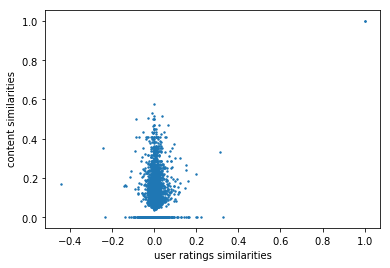

In [26]:
# load data
rating_pairs_train, rating_pairs_test, map_index2userid_train, map_index2movieid_train, map_userid2index_train, map_movieid2index_train = split_traintest("T1")
rating_pairs_train, rating_pairs_test = list(rating_pairs_train), list(rating_pairs_test)
rating_pairs_train.extend(rating_pairs_test)
# get feature vectors for all movies
print("computing content based similarities")
feat_mat_train, _, featurenames = get_features_mats(map_index2movieid_train, [])
# normalize them to have length 1 (since features are binary, norm is just the sqrt(sum()))
N = np.sqrt(feat_mat_train.sum(1))
print("%i movies have no features...:/" % np.sum(N==0))
N[N==0] = 1
feat_mat_train_normed = feat_mat_train/N
# compute content based similarity matrix ("similar movies have similar genres/directors/topics")
S_content = feat_mat_train_normed.dot(feat_mat_train_normed.T).A  # cosine similarity
# get sparse matrix with residuals
print("computing user ratings based similarities")
# initalize and fit means model
mmodel = MeansModel()
mmodel.fit(tuple_ratings, rating_pairs_train)
residual_ratings = mmodel.compute_residuals(tuple_ratings, rating_pairs_train)
# transform residual_ratings into a dict with {movieid: {userid: rating}}
residual_ratings_movies = defaultdict(dict)
for (m, u) in residual_ratings:
    residual_ratings_movies[m][u] = residual_ratings[(m, u)]
# normalize rating vectors to have unit length
for m in residual_ratings_movies:
    N = np.linalg.norm(list(residual_ratings_movies[m].values())) 
    residual_ratings_movies[m] = {u: residual_ratings_movies[m][u]/N for u in residual_ratings_movies[m]}
# transform into sparse matrix
ratings_matrix = dok_matrix((len(map_movieid2index_train), len(map_userid2index_train)), dtype=float)
for i, m in enumerate(map_index2movieid_train):
    for u in residual_ratings_movies[m]:
        ratings_matrix[i, map_userid2index_train[u]] = residual_ratings_movies[m][u]
ratings_matrix = csr_matrix(ratings_matrix)
# compute user ratings based similarity matrix ("similar movies get similar ratings")
S_user = ratings_matrix.dot(ratings_matrix.T).A
# check correlation between both similarity scores (--> if movies with similar content also 
# get similar ratings, the content based similarity score can be used for recommendations)
s_content_flat = np.asarray(S_content[np.triu_indices_from(S_content)])
s_user_flat = np.asarray(S_user[np.triu_indices_from(S_user)])
corr_pear = pearsonr(s_content_flat, s_user_flat)[0]
corr_spear = spearmanr(s_content_flat, s_user_flat)[0]
print("Correlation between ratings:", corr_pear, corr_spear)
ridx = np.random.permutation(len(s_content_flat))[:5000]
plt.figure()
plt.scatter(s_user_flat[ridx], s_content_flat[ridx], s=2)
plt.xlabel("user ratings similarities")
plt.ylabel("content similarities");

Epoch 1/20
10604/10604 [==============================] - 25s 2ms/step - loss: 0.0100
Epoch 2/20
10604/10604 [==============================] - 25s 2ms/step - loss: 0.0078
Epoch 3/20
10604/10604 [==============================] - 25s 2ms/step - loss: 0.0077
Epoch 4/20
10604/10604 [==============================] - 25s 2ms/step - loss: 0.0077
Epoch 5/20
10604/10604 [==============================] - 25s 2ms/step - loss: 0.0077
Epoch 6/20
10604/10604 [==============================] - 25s 2ms/step - loss: 0.0077
Epoch 7/20
10604/10604 [==============================] - 25s 2ms/step - loss: 0.0077
Epoch 8/20
10604/10604 [==============================] - 25s 2ms/step - loss: 0.0076
Epoch 9/20
10604/10604 [==============================] - 25s 2ms/step - loss: 0.0076
Epoch 10/20
10604/10604 [==============================] - 25s 2ms/step - loss: 0.0076
Epoch 11/20
10604/10604 [==============================] - 25s 2ms/step - loss: 0.0076
Epoch 12/20
10604/10604 [===========================

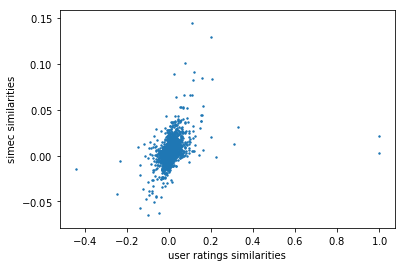

In [27]:
# train a simec to map the movie feature vectors into an embedding space,
# where the user rating based similarities are preserved
e_dim = 100
n_targets = 1000
model = SimilarityEncoder(feat_mat_train.shape[1], e_dim, n_targets, [(500, "tanh")], sparse_inputs=True, opt=0.001,
                          s_ll_reg=10., S_ll=S_user[:n_targets, :n_targets])
model.fit(feat_mat_train, S_user[:, :n_targets], epochs=20)
# compute embeddings for movies
X_embed = model.transform(feat_mat_train)
# compute simec similarity and check correlation
print (S_user[0,:6])
print (model.predict(feat_mat_train)[0,:6])
S_simec = X_embed.dot(X_embed.T)
print (S_simec[0,:6])
s_simec_flat = np.asarray(S_simec[np.triu_indices_from(S_simec)])
corr_pear = pearsonr(s_simec_flat, s_user_flat)[0]
corr_spear = spearmanr(s_simec_flat, s_user_flat)[0]
print("Correlation between ratings:", corr_pear, corr_spear)
plt.figure()
plt.scatter(s_user_flat[ridx], s_simec_flat[ridx], s=2)
plt.xlabel("user ratings similarities")
plt.ylabel("simec similarities");